In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pydicom
import pandas as pd
from glob import glob
import os
from matplotlib.patches import Rectangle
det_class_path = 'stage_2_detailed_class_info.csv'
bbox_path = 'stage_2_train_labels.csv'
dicom_dir = 'stage_2_train_images/'

30227 class infos loaded
26684 patient cases


,patientId,class
18704,afddf7bc-bdb4-49c8-8cab-9e52bb00e7d2,Normal
14060,8bdcd25b-5fc0-4b4d-b279-96aaa3b409b1,No Lung Opacity / Not Normal
26410,eba80948-4a28-4909-9b2d-06a0175c830f,Lung Opacity


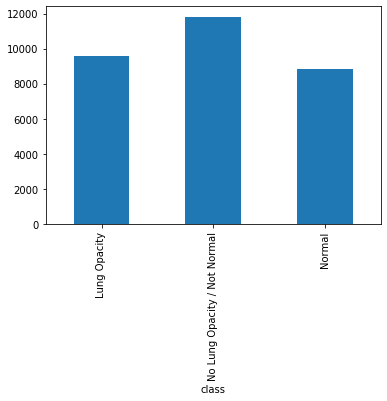

In [2]:
det_class_df = pd.read_csv(det_class_path)
print(det_class_df.shape[0], 'class infos loaded')
print(det_class_df['patientId'].value_counts().shape[0], 'patient cases')
det_class_df.groupby('class').size().plot.bar()
det_class_df.sample(3)

In [3]:
bbox_df = pd.read_csv(bbox_path)
print(bbox_df.shape[0], 'boxes loaded')
print(bbox_df['patientId'].value_counts().shape[0], 'patient cases')
bbox_df.sample(3)

30227 boxes loaded
26684 patient cases


,patientId,x,y,width,height,Target
5861,4a3a3320-ebd4-407c-ac5d-5baca4b71b9d,NaN,NaN,NaN,NaN,0
14016,8b8369dc-4085-4e1d-b1ca-5e1de60c15f0,488.0,188.0,307.0,704.0,1
2082,24dba8ea-22b9-4a3c-84ce-6bafeab8e6d1,652.0,503.0,83.0,147.0,1


In [4]:
comb_bbox_df = pd.merge(bbox_df, det_class_df, how='inner', on='patientId')
print(comb_bbox_df.shape[0], 'combined cases')

37629 combined cases


In [5]:
comb_bbox_df = pd.concat([bbox_df, 
                        det_class_df.drop('patientId',1)], 1)
print(comb_bbox_df.shape[0], 'combined cases')
comb_bbox_df.sample(3)

30227 combined cases


,patientId,x,y,width,height,Target,class
3030,35a379c4-1e56-41f7-8a25-a1c2e9b88464,568.0,438.0,193.0,154.0,1,Lung Opacity
24374,db0d9835-d96d-41c2-bb0f-2bbfa9e9b90f,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
4011,3c1e9e21-6e14-4ef7-a4ba-be8588e527ff,NaN,NaN,NaN,NaN,0,Normal


### Distribution of Boxes and Labels

In [6]:
box_df = comb_bbox_df.groupby('patientId').\
    size().\
    reset_index(name='boxes')
comb_box_df = pd.merge(comb_bbox_df, box_df, on='patientId')
box_df.\
    groupby('boxes').\
    size().\
    reset_index(name='patients')

,boxes,patients
0,1,23286
1,2,3266
2,3,119
3,4,13


### How are class and target related?

In [7]:

comb_bbox_df.groupby(['class', 'Target']).size().reset_index(name='Patient Count')

,class,Target,Patient Count
0,Lung Opacity,1,9555
1,No Lung Opacity / Not Normal,0,11821
2,Normal,0,8851


In [8]:

image_df = pd.DataFrame({'path': glob(os.path.join(dicom_dir, '*.dcm'))})
image_df['patientId'] = image_df['path'].map(lambda x: os.path.splitext(os.path.basename(x))[0])
print(image_df.shape[0], 'images found')
img_pat_ids = set(image_df['patientId'].values.tolist())
box_pat_ids = set(comb_box_df['patientId'].values.tolist())
# check to make sure there is no funny business
assert img_pat_ids.union(box_pat_ids)==img_pat_ids, "Patient IDs should be the same"

26684 images found


In [9]:
image_bbox_df = pd.merge(comb_box_df, 
                         image_df, 
                         on='patientId',
                        how='left').sort_values('patientId')
print(image_bbox_df.shape[0], 'image bounding boxes')
image_bbox_df.head(5)

30227 image bounding boxes


,patientId,x,y,width,height,Target,class,boxes,path
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,stage_2_train_images/0004cfab-14fd-4e49-80ba-6...
28989,000924cf-0f8d-42bd-9158-1af53881a557,NaN,NaN,NaN,NaN,0,Normal,1,stage_2_train_images/000924cf-0f8d-42bd-9158-1...
28990,000db696-cf54-4385-b10b-6b16fbb3f985,316.0,318.0,170.0,478.0,1,Lung Opacity,2,stage_2_train_images/000db696-cf54-4385-b10b-6...
28991,000db696-cf54-4385-b10b-6b16fbb3f985,660.0,375.0,146.0,402.0,1,Lung Opacity,2,stage_2_train_images/000db696-cf54-4385-b10b-6...
28992,000fe35a-2649-43d4-b027-e67796d412e0,570.0,282.0,269.0,409.0,1,Lung Opacity,2,stage_2_train_images/000fe35a-2649-43d4-b027-e...


In [ ]:
DCM_TAG_LIST = ['PatientAge', 'BodyPartExamined', 'ViewPosition', 'PatientSex']
def get_tags(in_path):
    c_dicom = pydicom.read_file(in_path, stop_before_pixels=False)
    tag_dict = {c_tag: getattr(c_dicom, c_tag, '') 
         for c_tag in DCM_TAG_LIST}
    tag_dict['path'] = in_path
    return pd.Series(tag_dict)
image_meta_df = image_df.apply(lambda x: get_tags(x['path']), 1)
# show the summary
image_meta_df['PatientAge'] = image_meta_df['PatientAge'].map(int)
image_meta_df['PatientAge'].hist()
image_meta_df.drop('path',1).describe(exclude=np.number)

In [11]:
image_full_df = pd.merge(image_df,
                         image_meta_df,
                         on='path')

### Create Sample Data Set

In [12]:
sample_df = image_bbox_df.\
    groupby(['Target','class', 'boxes']).\
    apply(lambda x: x[x['patientId']==x.sample(1)['patientId'].values[0]]).\
    reset_index(drop=True)
sample_df

,patientId,x,y,width,height,Target,class,boxes,path
0,389eeec2-92b6-4a26-8d47-6dda5567dce2,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,stage_2_train_images/389eeec2-92b6-4a26-8d47-6...
1,5d891e1c-08bc-4def-a56d-5748cbdc6d34,NaN,NaN,NaN,NaN,0,Normal,1,stage_2_train_images/5d891e1c-08bc-4def-a56d-5...
2,9f1ab54d-5fb8-4464-9617-26a7d25f26cd,604.0,417.0,253.0,288.0,1,Lung Opacity,1,stage_2_train_images/9f1ab54d-5fb8-4464-9617-2...
3,0e724a83-c104-4d33-94a5-c7df6174f40f,577.0,227.0,213.0,374.0,1,Lung Opacity,2,stage_2_train_images/0e724a83-c104-4d33-94a5-c...
4,0e724a83-c104-4d33-94a5-c7df6174f40f,266.0,219.0,170.0,357.0,1,Lung Opacity,2,stage_2_train_images/0e724a83-c104-4d33-94a5-c...
5,3f167f68-6cde-478d-8e78-9ae22529c22f,618.0,406.0,137.0,224.0,1,Lung Opacity,3,stage_2_train_images/3f167f68-6cde-478d-8e78-9...
6,3f167f68-6cde-478d-8e78-9ae22529c22f,225.0,303.0,161.0,169.0,1,Lung Opacity,3,stage_2_train_images/3f167f68-6cde-478d-8e78-9...
7,3f167f68-6cde-478d-8e78-9ae22529c22f,305.0,488.0,124.0,207.0,1,Lung Opacity,3,stage_2_train_images/3f167f68-6cde-478d-8e78-9...
8,31764d54-ea3b-434f-bae2-8c579ed13799,649.0,319.0,190.0,172.0,1,Lung Opacity,4,stage_2_train_images/31764d54-ea3b-434f-bae2-8...
9,31764d54-ea3b-434f-bae2-8c579ed13799,293.0,311.0,166.0,167.0,1,Lung Opacity,4,stage_2_train_images/31764d54-ea3b-434f-bae2-8...


### Show the position and bounding box

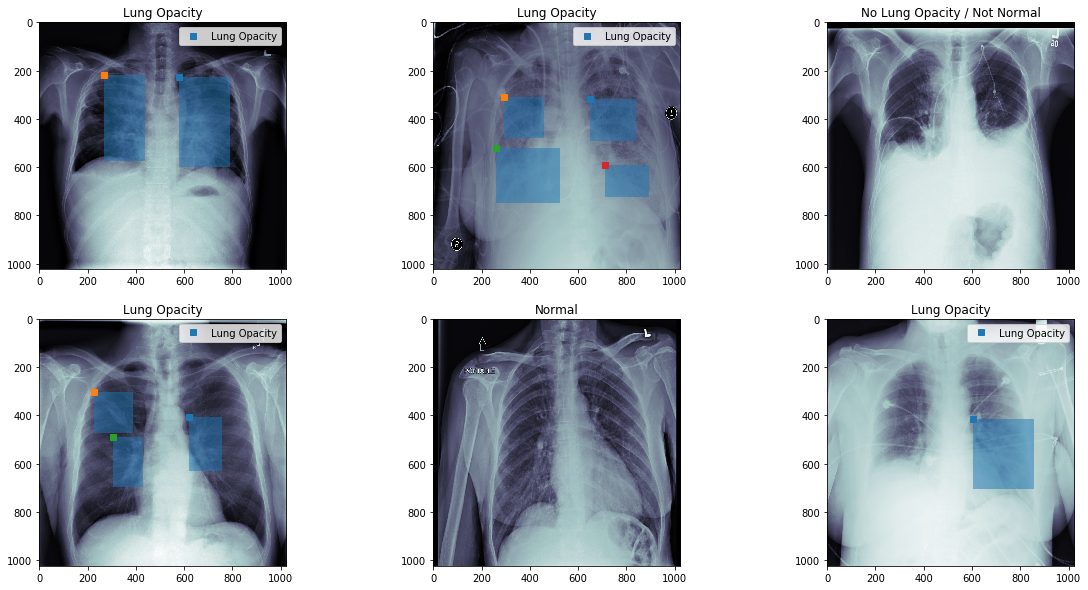

In [13]:
fig, m_axs = plt.subplots(2, 3, figsize = (20, 10))
for c_ax, (c_path, c_rows) in zip(m_axs.flatten(),
                    sample_df.groupby(['path'])):
    c_dicom = pydicom.read_file(c_path)
    c_ax.imshow(c_dicom.pixel_array, cmap='bone')
    c_ax.set_title('{class}'.format(**c_rows.iloc[0,:]))
    for i, (_, c_row) in enumerate(c_rows.dropna().iterrows()):
        c_ax.plot(c_row['x'], c_row['y'], 's', label='{class}'.format(**c_row))
        c_ax.add_patch(Rectangle(xy=(c_row['x'], c_row['y']),
                                width=c_row['width'],
                                height=c_row['height'], 
                                 alpha = 0.5))
        if i==0: c_ax.legend()

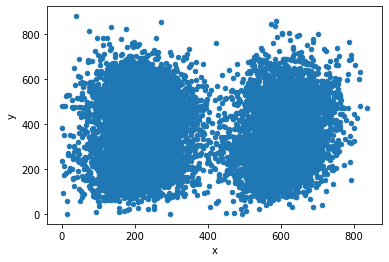

In [15]:
pos_bbox = image_bbox_df.query('Target==1')
pos_bbox.plot.scatter(x='x', y='y')

### Bounding Box Distribution

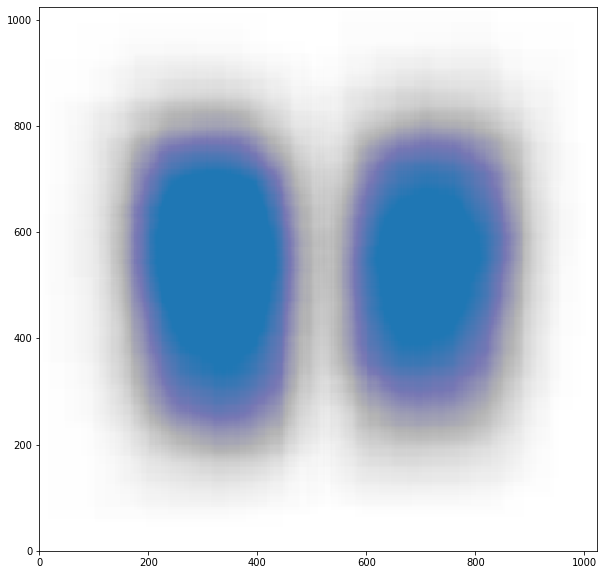

In [16]:
fig, ax1 = plt.subplots(1, 1, figsize = (10, 10))
ax1.set_xlim(0, 1024)
ax1.set_ylim(0, 1024)
for _, c_row in pos_bbox.sample(1000).iterrows():
    ax1.add_patch(Rectangle(xy=(c_row['x'], c_row['y']),
                 width=c_row['width'],
                 height=c_row['height'],
                           alpha=5e-3))

### Show the boxes as segmentation

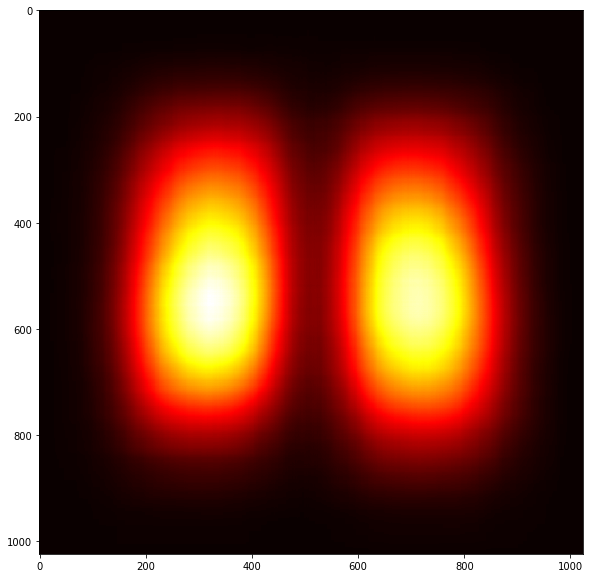

In [17]:
# Show the boxes themselves
X_STEPS, Y_STEPS = 1024, 1024
xx, yy = np.meshgrid(np.linspace(0, 1024, X_STEPS),
           np.linspace(0, 1024, Y_STEPS), 
           indexing='xy')
prob_image = np.zeros_like(xx)
for _, c_row in pos_bbox.sample(5000).iterrows():
    c_mask = (xx>=c_row['x']) & (xx<=(c_row['x']+c_row['width']))
    c_mask &= (yy>=c_row['y']) & (yy<=c_row['y']+c_row['height'])
    prob_image += c_mask
fig, ax1 = plt.subplots(1, 1, figsize = (10, 10))
ax1.imshow(prob_image, cmap='hot')

### Overlay the Probability on a few images

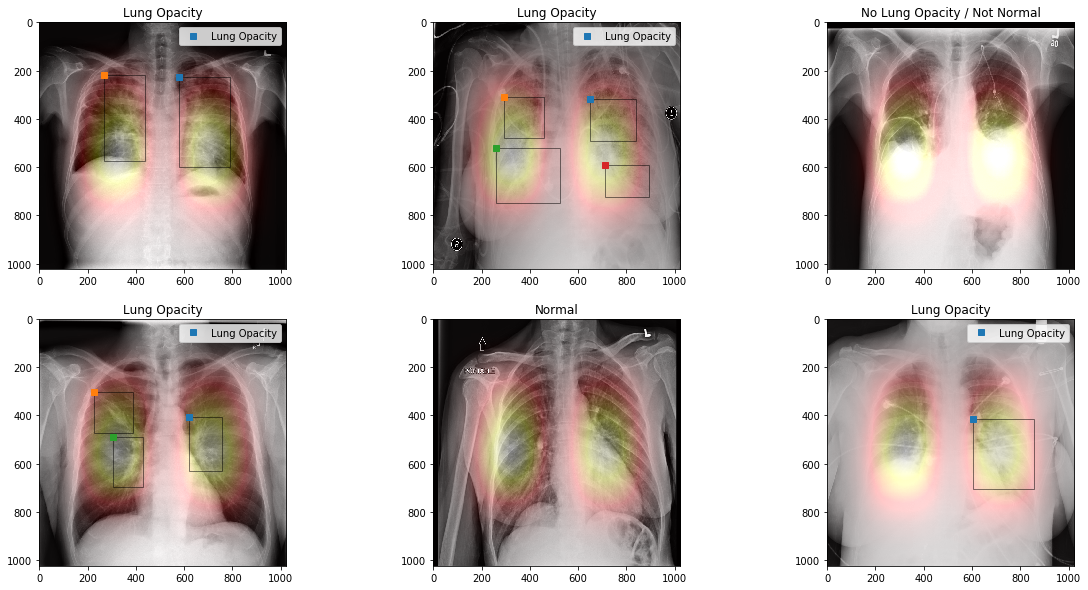

In [18]:
fig, m_axs = plt.subplots(2, 3, figsize = (20, 10))
for c_ax, (c_path, c_rows) in zip(m_axs.flatten(),
                    sample_df.groupby(['path'])):
    c_img_arr = pydicom.read_file(c_path).pixel_array
    # overlay
    c_img = plt.cm.gray(c_img_arr)
    c_img += 0.25*plt.cm.hot(prob_image/prob_image.max())
    c_img = np.clip(c_img, 0, 1)
    c_ax.imshow(c_img)
    
    c_ax.set_title('{class}'.format(**c_rows.iloc[0,:]))
    for i, (_, c_row) in enumerate(c_rows.dropna().iterrows()):
        c_ax.plot(c_row['x'], c_row['y'], 's', label='{class}'.format(**c_row))
        c_ax.add_patch(Rectangle(xy=(c_row['x'], c_row['y']),
                                width=c_row['width'],
                                height=c_row['height'], 
                                 alpha = 0.5,
                                fill=False))
        if i==0: c_ax.legend()
fig.savefig('overview.png', figdpi = 600)